<a href="https://colab.research.google.com/github/FrankArcosAnselmo/mI_lab01_Fa/blob/develop/LAB07_ARCOS_FRANK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 07
# NOMBRE: ARCOS ANSELMO FRANK
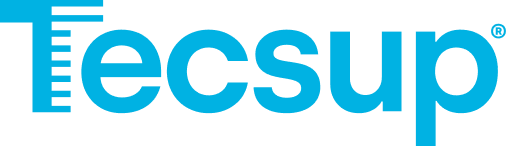

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calcule el information value (IV), tanto para el grupo de variable numéricas como categóricas y excluya las que tenga un poder predictivo débil o menor Además, separe la variable de Clasificación del resto de variables para luego obtener los datos de entrenamiento y prueba,tomando de este último el 25% de datos.

In [14]:
# Cargar los datos desde la URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
columnas = ['ID', 'Clump_Thickness', 'Uniformity_Cell_Size', 'Uniformity_Cell_Shape',
            'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei',
            'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses', 'Class']

df = pd.read_csv(url, names=columnas)

# Reemplazar valores faltantes
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)
df['Bare_Nuclei'] = df['Bare_Nuclei'].astype(int)

# Separar variable objetivo
df['Class'] = df['Class'].map({2: 0, 4: 1})  # 0: benign, 1: malignant
df.head()

,ID,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


#B)Genere el modelo de regresión logística y evalúe la exclusión de variables mediante la significancia de los coeficientes. Además, calcule las métricas de clasificación que se implementaron en la parte práctica e interprete sus resultados más importantes.

In [4]:
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import chi2_contingency

def calc_iv(df, feature, target, bins=10):
    df_temp = df.copy()
    if df[feature].nunique() > bins:
        df_temp[feature] = pd.qcut(df[feature], bins, duplicates='drop')

    iv = 0
    for cat in df_temp[feature].unique():
        temp = df_temp[df_temp[feature] == cat]
        good = ((temp[target] == 0).sum()) / (df_temp[target] == 0).sum()
        bad = ((temp[target] == 1).sum()) / (df_temp[target] == 1).sum()
        if good > 0 and bad > 0:
            iv += (bad - good) * np.log(bad / good)
    return iv

# Calcular IV de todas las variables
iv_dict = {}
features = df.columns.drop(['ID', 'Class'])
for col in features:
    iv_dict[col] = calc_iv(df, col, 'Class')

iv_df = pd.DataFrame.from_dict(iv_dict, orient='index', columns=['IV']).sort_values(by='IV', ascending=False)
print(iv_df)


                                   IV
Uniformity_Cell_Shape        5.290828
Bare_Nuclei                  4.903711
Uniformity_Cell_Size         4.189561
Single_Epithelial_Cell_Size  4.159839
Bland_Chromatin              3.476306
Marginal_Adhesion            2.915431
Normal_Nucleoli              2.270390
Clump_Thickness              2.259355
Mitoses                      1.026203


In [5]:
from sklearn.model_selection import train_test_split

X = df[iv_df[iv_df['IV'] >= 0.02].index]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [6]:
import statsmodels.api as sm
import sklearn.metrics as metrics

X_train_sm = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_sm).fit()
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.073760
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:                  512
Model:                          Logit   Df Residuals:                      502
Method:                           MLE   Df Model:                            9
Date:                Wed, 30 Apr 2025   Pseudo R-squ.:                  0.8842
Time:                        23:49:32   Log-Likelihood:                -37.765
converged:                       True   LL-Null:                       -326.13
Covariance Type:            nonrobust   LLR p-value:                2.070e-118
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -10.0640      1.408     -7.150      0.000   

## C) Genere el modelo SVM, calcule sus métricas de clasificación y compárelas con las del modelo de regresión logística para ver si hubo o no mejoras

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("AUC ROC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))


[[102   1]
 [  7  61]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       103
           1       0.98      0.90      0.94        68

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

AUC ROC: 0.9984294688749287


In [8]:
from sklearn.svm import SVC

svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
print("AUC ROC:", roc_auc_score(y_test, svm.predict_proba(X_test)[:, 1]))


[[101   2]
 [  7  61]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       103
           1       0.97      0.90      0.93        68

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

AUC ROC: 0.9968589377498572


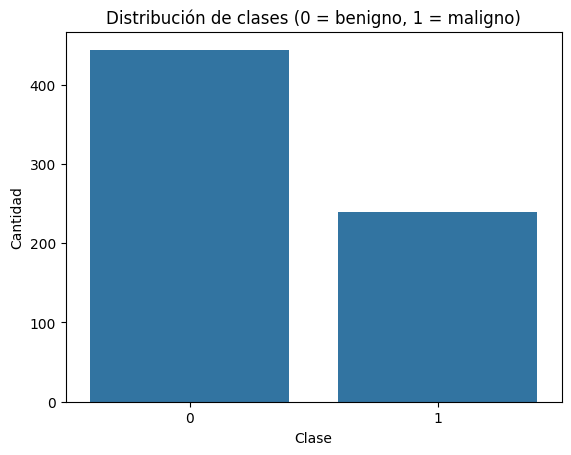

In [15]:
sns.countplot(data=df, x='Class')
plt.title('Distribución de clases (0 = benigno, 1 = maligno)')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()


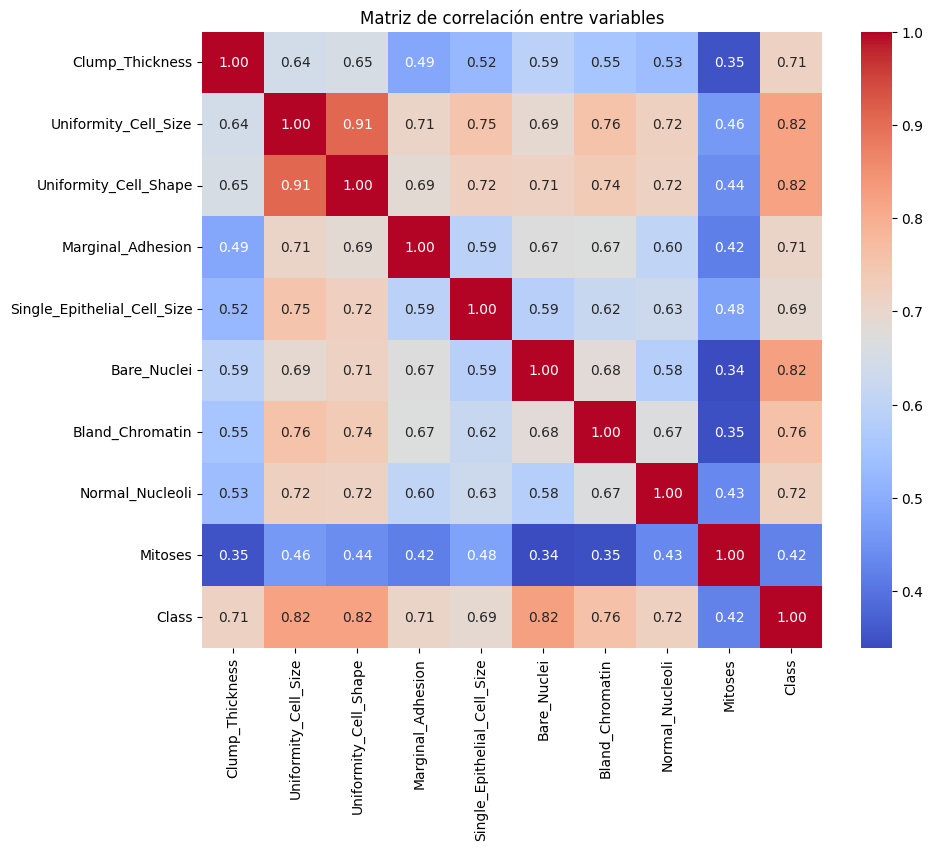

In [18]:
plt.figure(figsize=(10, 8))
corr = df.drop(columns='ID').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación entre variables')
plt.show()


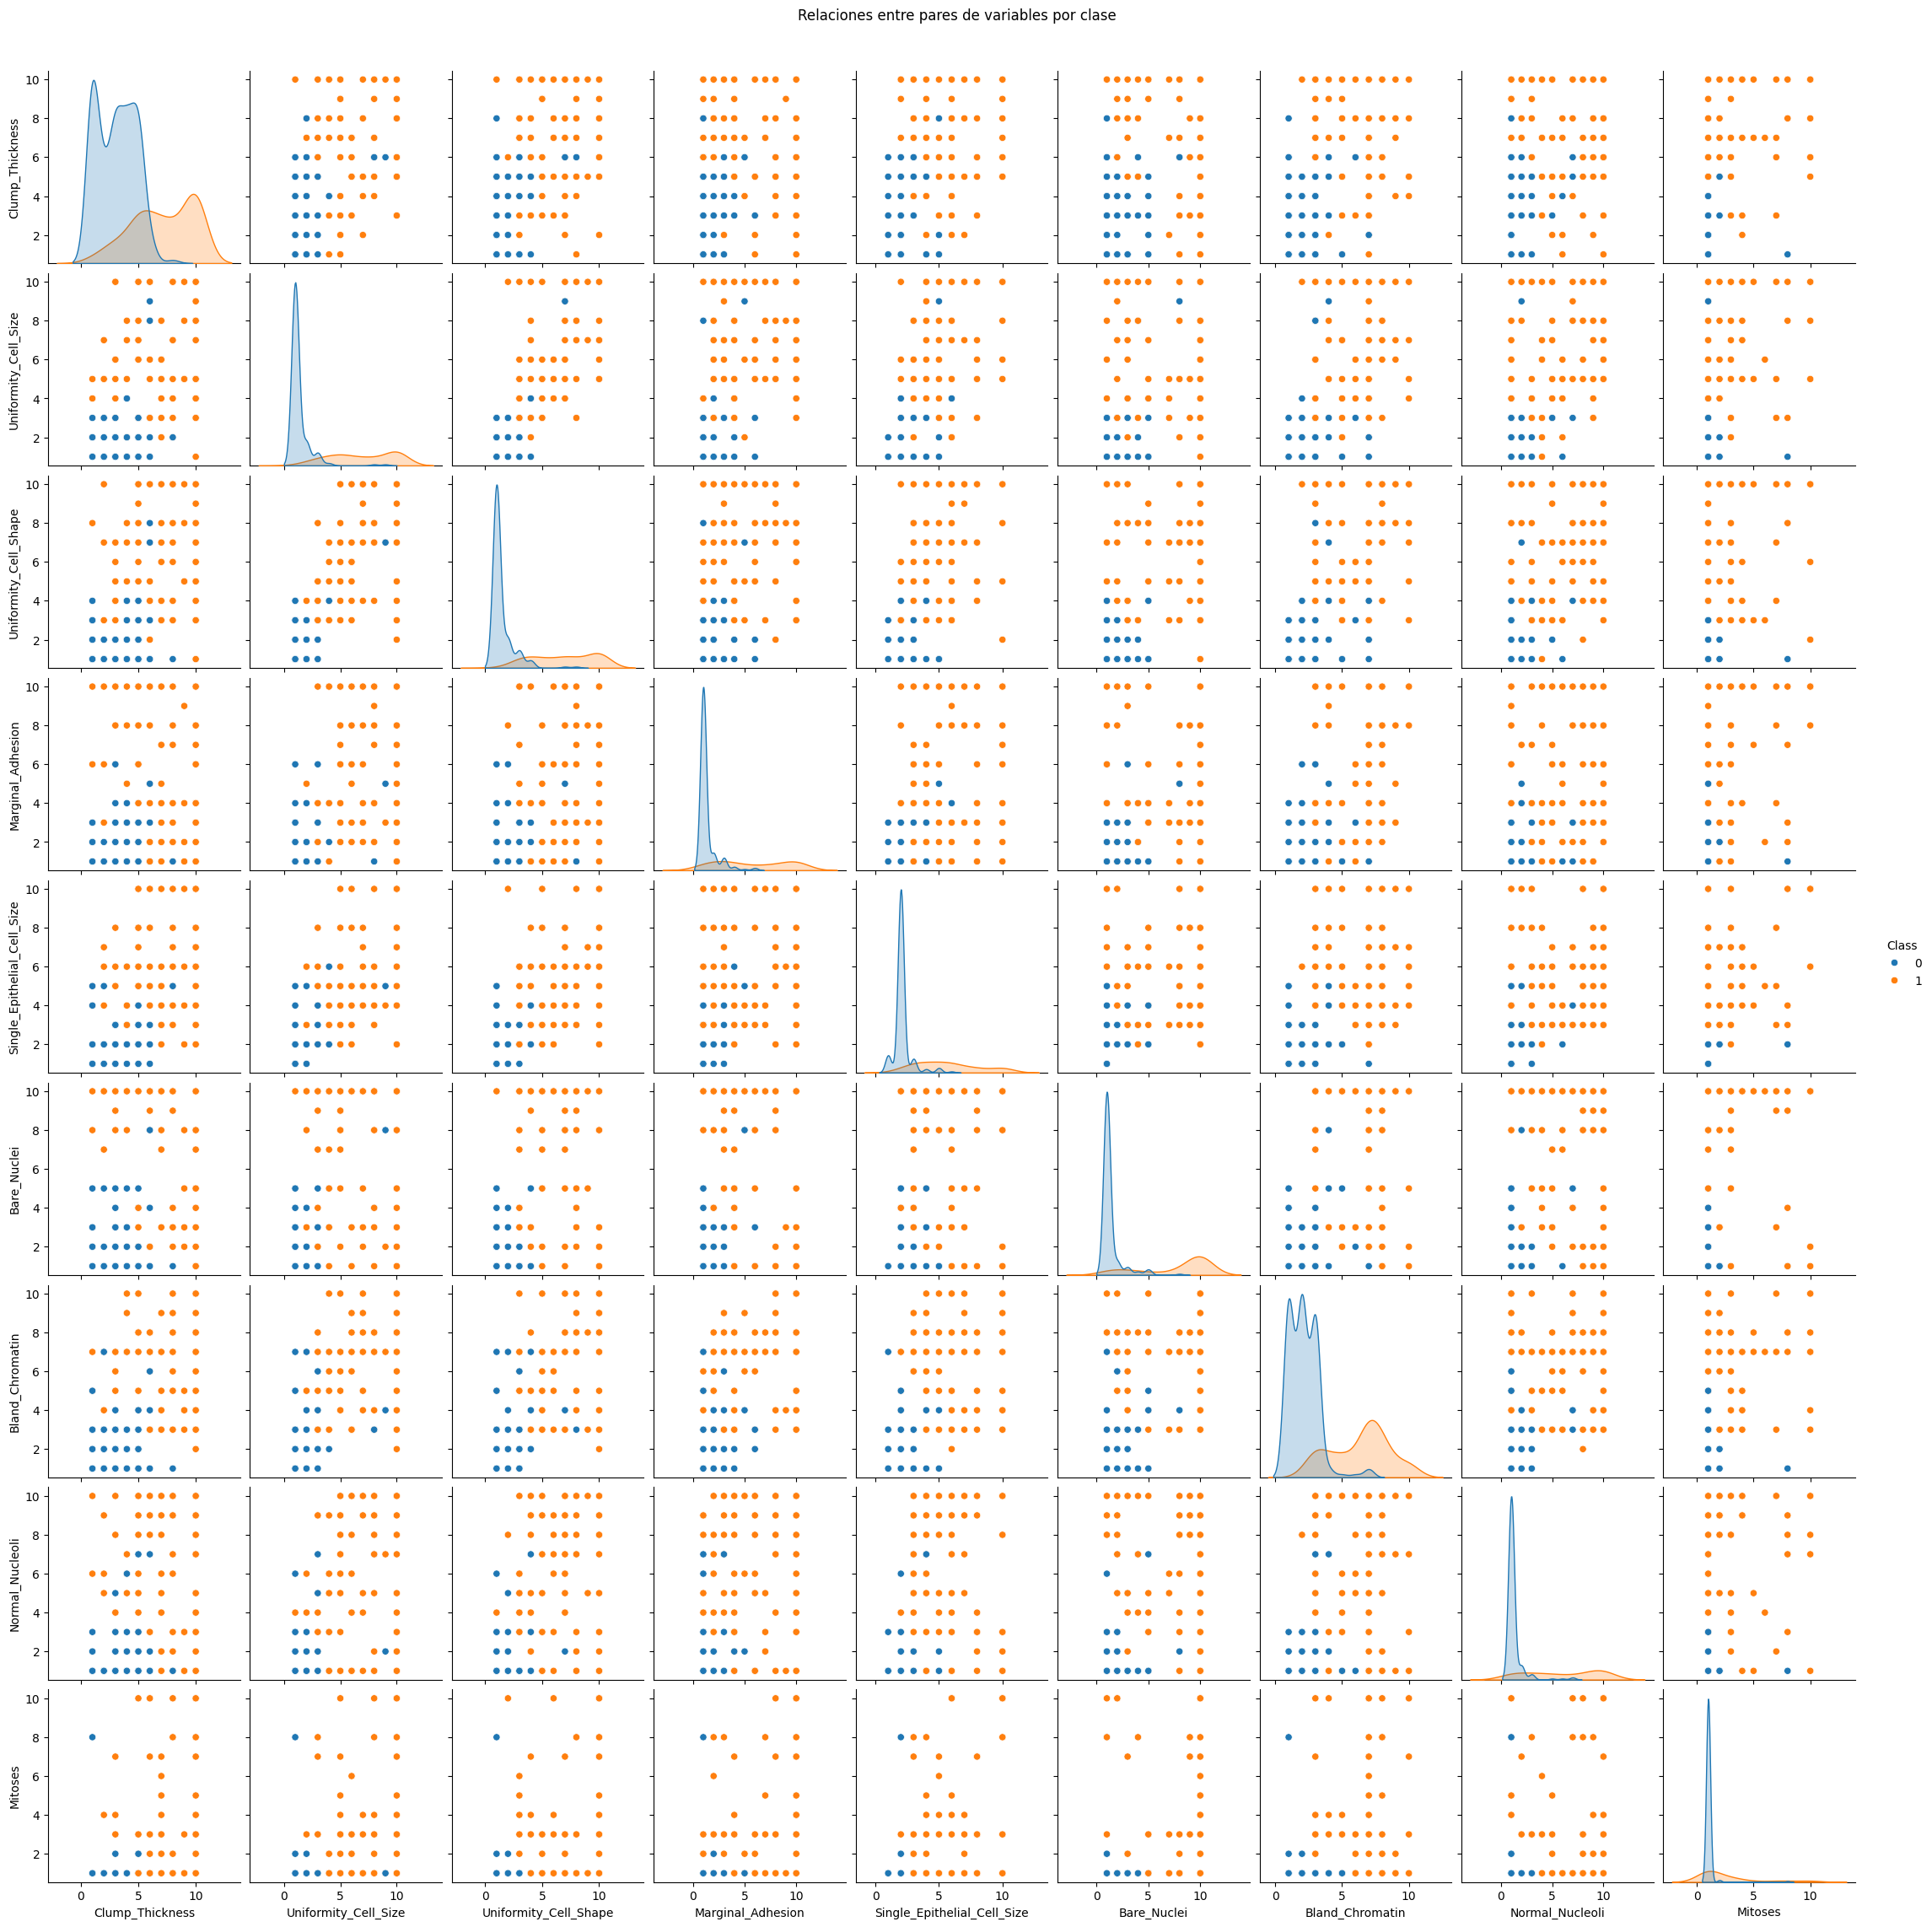

In [19]:
# Usar una muestra pequeña si el rendimiento es un problema
sample_df = df.sample(300, random_state=1)

sns.pairplot(sample_df, hue='Class', vars=df.columns[1:-1])
plt.suptitle('Relaciones entre pares de variables por clase', y=1.02)
plt.show()


# Matriz de Confusion

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar y limpiar los datos
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
columnas = ['ID', 'Clump_Thickness', 'Uniformity_Cell_Size', 'Uniformity_Cell_Shape',
            'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei',
            'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses', 'Class']

df = pd.read_csv(url, names=columnas)
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)
df['Bare_Nuclei'] = df['Bare_Nuclei'].astype(int)
df['Class'] = df['Class'].map({2: 0, 4: 1})  # 0: benigno, 1: maligno

# Variables predictoras y variable objetivo
X = df.drop(columns=['ID', 'Class'])
y = df['Class']


In [22]:
# División 75% entrenamiento / 25% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [23]:
# Entrenar el modelo de regresión logística
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

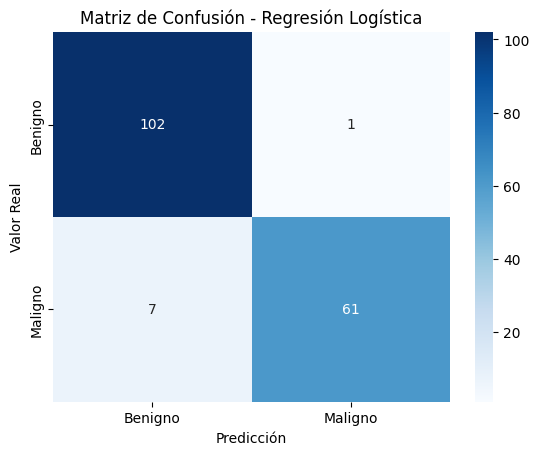

In [24]:
# Realizar las predicciones en el conjunto de prueba
y_pred = lr.predict(X_test)

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión usando seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()
